In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

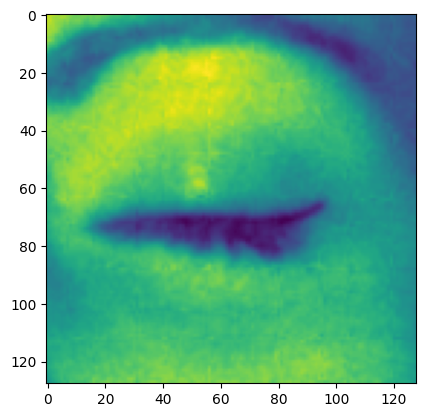

In [ ]:
data = torch.load('/content/drive/MyDrive/DEEP_LEARNING/DeepLearning/Project/Drowsiness/RawData/eyes_image.pth')
data = torch.stack(data)
plt.imshow(data[0].view(128, -1))

In [ ]:
data.shape

torch.Size([4000, 1, 128, 128])

In [ ]:
label = torch.load('/content/drive/MyDrive/DEEP_LEARNING/DeepLearning/Project/Drowsiness/RawData/label.pth')
label = torch.tensor(label)
print(label.shape)
print(label)

torch.Size([4000])
tensor([1, 1, 1,  ..., 0, 0, 0])


In [ ]:
new_label = []
for i in range(len(label)):
  if label[i] == 1:
    new_label.append(torch.tensor([[0., 1.]]))
  else:
    new_label.append(torch.tensor([[1., 0.]]))
new_label = torch.stack(new_label)
new_label.shape

torch.Size([4000, 1, 2])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# Tạo dataset từ dữ liệu ảnh và nhãn của bạn
dataset = CustomDataset(data, label)

In [ ]:
len(dataset)
dataset[0][0]

tensor([[[0.6196, 0.6196, 0.6196,  ..., 0.3647, 0.3647, 0.3725],
         [0.6157, 0.6118, 0.5961,  ..., 0.3608, 0.3608, 0.3686],
         [0.6118, 0.6157, 0.6000,  ..., 0.3569, 0.3569, 0.3647],
         ...,
         [0.4706, 0.4863, 0.5020,  ..., 0.4784, 0.4745, 0.4784],
         [0.4667, 0.4784, 0.4941,  ..., 0.4824, 0.4745, 0.4706],
         [0.4588, 0.4667, 0.4824,  ..., 0.4902, 0.4824, 0.4667]]])

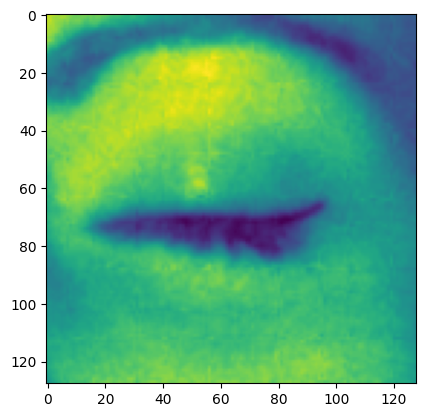

In [ ]:
plt.imshow(dataset[0][0].view(128, -1))

In [ ]:
dataset[0][1]

tensor(1)

In [ ]:
data_train, data_test = train_test_split(dataset, test_size = 0.2)

In [ ]:
len(data_train)

3200

In [ ]:
trainLoader = DataLoader(dataset = data_train, batch_size = 128, shuffle = True)
testLoader = DataLoader(dataset = data_test, batch_size = 128, shuffle = False)

In [ ]:
class VGG16(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = self.make_feature()
    self.classification_head = nn.Linear(in_features = 8192, out_features = 2)

  def forward(self, x):
    out = self.features(x)
    out = out.view(out.size(0), -1)
    out = self.classification_head(out)
    return out

  def make_feature(self):
    config = [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP']
    layers = []
    c_in = 1
    for c in config:
      if c == 'MP':
        layers += [nn.MaxPool2d(kernel_size = 2, stride = 2)]
      else:
        layers += [nn.Conv2d(in_channels = c_in, out_channels = c, kernel_size = 3, stride = 1, padding = 1),
                   nn.BatchNorm2d(num_features = c),
                   nn.ReLU6(inplace = True)]
        c_in = c
    return nn.Sequential(*layers)

In [ ]:
len(trainLoader)

25

In [ ]:
def train_epoch(epoch, model, loader, loss_func, optimizer, device, a):

    model.train()
    running_loss = 0.0
    reporting_steps = 5
    for i, (image, label) in enumerate(loader):
      image, label = image.to(device), label.to(device)
      output = model(image)
      loss = loss_func(output, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      if i % reporting_steps == reporting_steps - 1:
        print(f"Epoch {epoch} step {i} ave loss {running_loss/reporting_steps: .4f}")
        a.append(running_loss)
        running_loss = 0.0

def test_epoch(epoch, model, loader, device):
    ytrue = []
    ypred = []
    with torch.no_grad():
      model.eval()

      reporting_steps = 60
      for i, (image, label) in enumerate(loader):
        image, label = image.to(device), label.to(device)
        output = model(image)
        _, predicted = torch.max(output, dim = 1)

        ytrue += list(label.cpu().numpy())
        ypred += list(predicted.cpu().numpy())

      return ypred, ytrue

In [ ]:
run_loss = []
accu = []
device = torch.device("cuda")
model = VGG16().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)
for epoch in range(20):
  train_epoch(epoch, model, trainLoader, loss_func, optimizer, device, run_loss)
  ypred, ytrue = test_epoch(epoch, model, testLoader, device)
  accu.append(accuracy_score(ytrue, ypred))
  print(classification_report(ytrue, ypred))

Epoch 0 step 4 ave loss  3.9626
Epoch 0 step 9 ave loss  0.8136
Epoch 0 step 14 ave loss  3.9156
Epoch 0 step 19 ave loss  0.9942
Epoch 0 step 24 ave loss  0.4684
              precision    recall  f1-score   support

           0       0.52      0.68      0.59       395
           1       0.55      0.38      0.45       405

    accuracy                           0.53       800
   macro avg       0.53      0.53      0.52       800
weighted avg       0.54      0.53      0.52       800

Epoch 1 step 4 ave loss  0.4395
Epoch 1 step 9 ave loss  0.5417
Epoch 1 step 14 ave loss  0.7436
Epoch 1 step 19 ave loss  0.4605
Epoch 1 step 24 ave loss  0.4698
              precision    recall  f1-score   support

           0       0.99      0.56      0.72       395
           1       0.70      1.00      0.82       405

    accuracy                           0.78       800
   macro avg       0.84      0.78      0.77       800
weighted avg       0.84      0.78      0.77       800

Epoch 2 step 4 ave l

In [ ]:
print(accu)

[0.53, 0.78, 0.73875, 0.815, 0.8075, 0.94, 0.8825, 0.9725, 0.98625, 0.995, 0.99, 0.99375, 0.995, 0.99125, 0.99625, 0.9975, 0.9975, 0.995, 0.9975, 0.9975]


In [ ]:
print(run_loss)

[19.813217520713806, 4.067817747592926, 19.57818576693535, 4.971037894487381, 2.3421200811862946, 2.197466254234314, 2.7087135016918182, 3.7180643677711487, 2.3025446832180023, 2.348781645298004, 2.316668748855591, 2.0728005468845367, 1.982987403869629, 2.0103656351566315, 1.8208209574222565, 1.8755696415901184, 1.7998470067977905, 1.6941397786140442, 3.095184415578842, 1.9463314712047577, 2.240831881761551, 1.6864949762821198, 2.1725734770298004, 1.7166284620761871, 1.7505989372730255, 2.0205601155757904, 1.6110325753688812, 1.5093782246112823, 1.4840259552001953, 1.1914150565862656, 1.0182201266288757, 1.6506955102086067, 0.5547213032841682, 0.7053659409284592, 1.4915096908807755, 1.21140256524086, 0.6785186007618904, 0.5417130962014198, 0.39610370621085167, 0.4716978743672371, 0.45651013404130936, 0.28611627221107483, 0.29277491196990013, 0.2774042468518019, 0.2564206002280116, 0.18363161198794842, 0.17088556103408337, 0.13823017664253712, 0.22781783156096935, 0.19940602499991655, 0

Text(0, 0.5, 'Loss')

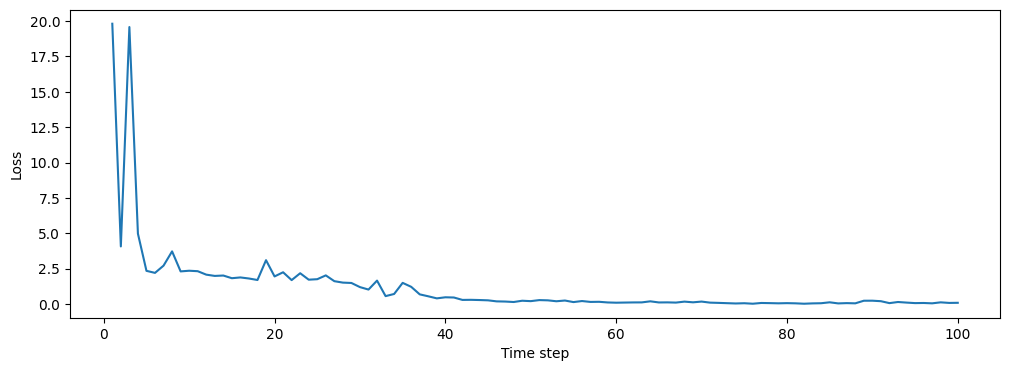

In [ ]:
#plot loss
time_step = np.arange(1, len(run_loss) + 1, dtype = int)
plt.figure(figsize = (12, 4))
plt.plot(time_step, run_loss)
plt.xlabel('Time step')
plt.ylabel('Loss')

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


Text(0, 0.5, 'Accuracy')

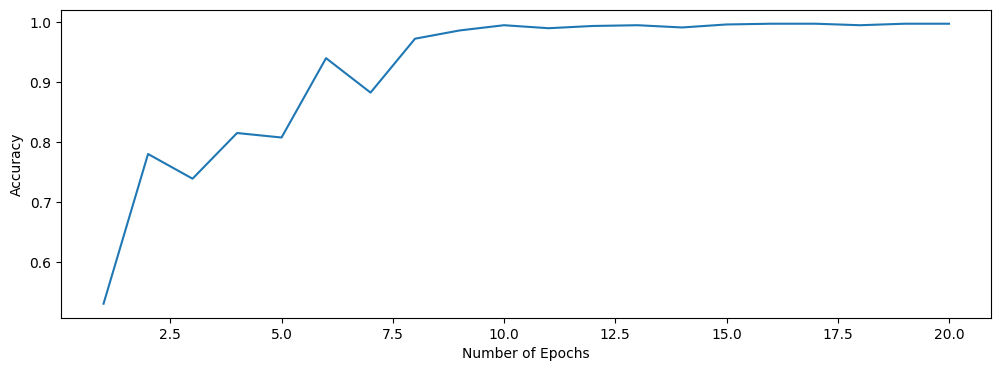

In [ ]:
#plot accuracy
epoch = np.arange(1, 21, dtype = int)
print(epoch)

plt.figure(figsize = (12, 4))
plt.plot(epoch, accu)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')